In [16]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os

def data_organizer(file_name):

    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    folder_path = 'Data'
    file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(file_path, names=col_names, sep='\s+', header=None)

    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    deleted_data = df[df["MonStatus"] != 1]
    print(f"Removed rows of data where Monitor Status is not 1: {len(deleted_data)}\n")
    df = df[df["MonStatus"] == 1]
    
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')
    
    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                         month=df['Date'].dt.month,
                                         day=df['Date'].dt.day,
                                         hour=df['Time'].dt.hour,
                                         minute=df['Time'].dt.minute,
                                         second=df['Time'].dt.second))
    
    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)
    
    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}
    
    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    spiders = []
    
    for i in range(1, 33):
        if df[f"Sp{i}"].sum() > 10:
            spiders.append(i)
        if not i in spiders:
            df = df.drop([f"Sp{i}"], axis=1)

    return df, spiders

def naming_pattern(file_name):
    group_name = file_name.split(' ', 2)[0]
    light_condition = file_name.split(' ', 2)[1]
    start_date = file_name.split(' ', 2)[2].split('-', 1)[0]
    
    path = group_name + "_" + light_condition + "_" + start_date
    
    two_lights = False
    if "-" in light_condition:
        #li_con_1, li_con_2 = light_condition.split('-', 1)
        two_lights = True

    return group_name, light_condition, start_date, path, two_lights


In [17]:
file_name = 'StA LD-DD 0118-0201-2024.txt'

df, spiders = data_organizer(file_name)

display(df)
display(spiders)

Removed rows of data where Monitor Status is not 1: 0



,Day,Time,Light,Sp3,Sp4,Sp5,Sp6,Sp7,Sp9,Sp10,...,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23,Sp24,Sp25
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-01-18 13:17:00,1,15,9,12,10,17,11,6,...,5,8,5,10,11,5,4,6,6,4
2,1,2024-01-18 13:18:00,1,0,0,1,0,1,1,0,...,1,0,1,4,0,0,0,1,0,0
3,1,2024-01-18 13:19:00,1,0,0,1,0,2,4,0,...,6,0,2,0,0,0,0,3,0,20
4,1,2024-01-18 13:20:00,1,0,4,3,0,1,0,0,...,4,0,1,1,0,0,0,0,0,9
5,1,2024-01-18 13:21:00,1,0,3,3,0,0,0,0,...,2,0,3,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20417,15,2024-02-01 17:33:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20418,15,2024-02-01 17:34:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20419,15,2024-02-01 17:35:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25]

In [39]:
# Create a raster plot from a data frame of spider activity:
# Data frame format: Day, Time, Light, [Spider Names]
def rasterplot_binary(dataframe, spider_name, title, rolling_window=1):
    sp_df = dataframe[['Day', 'Time', 'Light', spider_name]]
    
    days = sp_df['Day'].unique()
    
    fig, axs = plt.subplots(len(days), 1)
    
    fig.suptitle(title)
    fig.supxlabel('Time (hrs)')
    fig.supylabel('Day')
    
    # Separate activity by day
    for day, ax in zip(days, axs):
        sp_day = sp_df[sp_df['Day'] == day]
        time = sp_day['Time'].dt.hour + sp_day['Time'].dt.minute / 60
        light = sp_day['Light']
        activity = sp_day[spider_name]
    
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_ylim(0, 1)
    
        ax.set_ylabel(day, rotation='horizontal')

        ax.fill_between(time, 0, 1, where=light, alpha=.5, color='yellow')
        ax.fill_between(time, 0, 1, where=(activity.rolling(rolling_window).mean() > 0), alpha=1)
    
    axs[-1].set_xticks(np.arange(0, 25, 2))
    axs[-1].set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal')

    return fig, axs

def rasterplot_line(dataframe, spider_name, title, rolling_window=1):
    sp_df = dataframe[['Day', 'Time', 'Light', spider_name]]
    
    days = sp_df['Day'].unique()
    
    fig, axs = plt.subplots(len(days), 1)
    
    fig.suptitle(title)
    fig.supxlabel('Time (hrs)')
    fig.supylabel('Day')
    
    # Separate activity by day
    for day, ax in zip(days, axs):
        sp_day = sp_df[sp_df['Day'] == day]
        time = sp_day['Time'].dt.hour + sp_day['Time'].dt.minute / 60
        light = sp_day['Light']
        activity = sp_day[spider_name]
    
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_ylim(0, 1)
    
        ax.set_ylabel(day, rotation='horizontal')

        ax.fill_between(time, 0, 1, where=light, alpha=.5, color='yellow')

        ax.plot(time, activity / max(activity))
    
    axs[-1].set_xticks(np.arange(0, 25, 2))
    axs[-1].set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal')

    return fig, axs


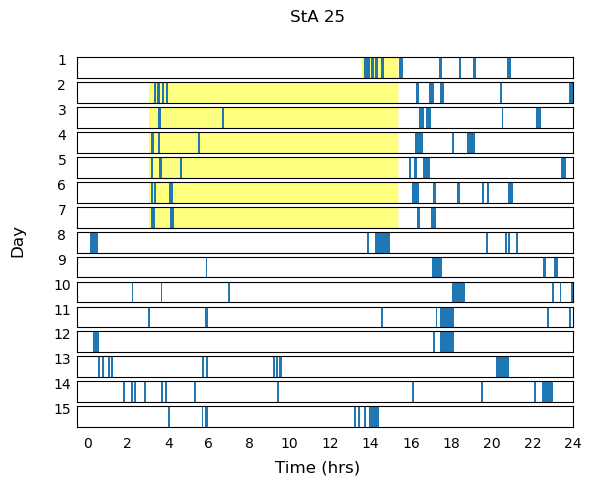

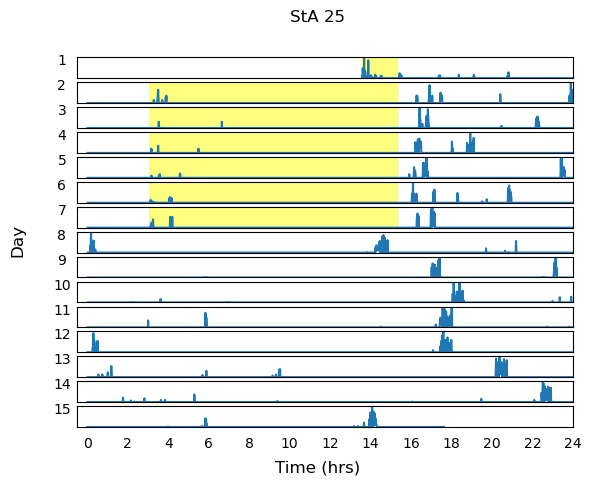

In [40]:
_, rp_axs_bin = rasterplot_binary(df, 'Sp25', 'StA 25', 6)
_, rp_axs_lin = rasterplot_line(df, 'Sp25', 'StA 25', 6)

In [11]:
def rasterplot_img(dataframe, spider_name, title, rolling_window=1):
    sp_df = dataframe[['Day', 'Time', 'Light', spider_name]]
    
    days = sp_df['Day'].unique()

    raster = np.empty((len(days), 1440))
    
    for activity, day, time in zip(sp_df[spider_name].rolling(rolling_window).mean(), sp_df['Day'], sp_df['Time']):
        time_min = time.hour * 60 + time.minute
        raster[day - 1, time_min] = activity
        
    return raster
    

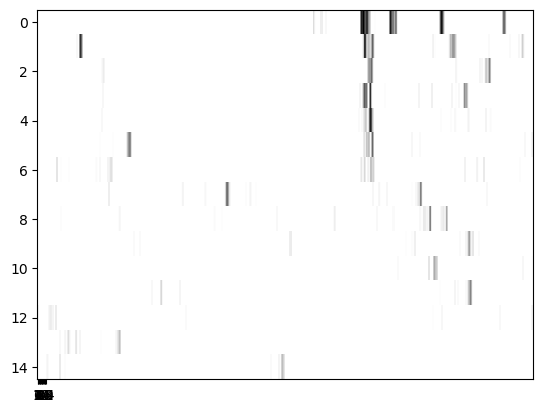

In [36]:
raster = rasterplot_img(df, 'Sp4', 'Spider 4 Activity', rolling_window=6)

fig, ax = plt.subplots(1, 1)

ax.set_xticks(np.arange(0, 25, 2))
ax.set_xticklabels(np.arange(0, 25, 2));
ax.imshow(raster, interpolation='none', aspect='auto', cmap='Greys')